In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, ccf
import numpy as np
import plotly.express as px
from datetime import datetime
import geopandas as gpd
import warnings
from datetime import datetime


from gosia_utils import * 


## Weather Dataset - opis, wizualizacje

##### na razie praca na jednym roku (2015) 

In [2]:
df = pd.read_csv(".\\data\\data\\NOAA_StormEvents\\StormEvents_details-ftp_v1.0_d2015_c20240716.csv")
out = pd.read_csv(".\\data\\data\\eaglei_data\\eaglei_outages_2015.csv")

##### opis kolumn - wygenerowane przez chatGPT, sprawdzilam i wszystko sie zgadza

- **BEGIN_YEARMONTH** – Rok i miesiąc rozpoczęcia zdarzenia (np. 201401 dla stycznia 2014).
- **BEGIN_DAY** – Dzień rozpoczęcia zdarzenia.  
- **BEGIN_TIME** – Godzina rozpoczęcia zdarzenia w formacie HHMM (np. 1530 oznacza 15:30).  
- **END_YEARMONTH** – Rok i miesiąc zakończenia zdarzenia.  
- **END_DAY** – Dzień zakończenia zdarzenia.  
- **END_TIME** – Godzina zakończenia zdarzenia.  
- **EPISODE_ID** – Identyfikator epizodu (unikalny numer przypisany do konkretnego epizodu pogodowego).  
- **EVENT_ID** – Identyfikator zdarzenia (unikalny numer przypisany do konkretnego zdarzenia w ramach epizodu).  
- **STATE** – Nazwa stanu, w którym wystąpiło zdarzenie.  
- **STATE_FIPS** – Kod FIPS (Federal Information Processing Standard) dla stanu.  
- **YEAR** – Rok, w którym miało miejsce zdarzenie.  
- **MONTH_NAME** – Nazwa miesiąca, w którym miało miejsce zdarzenie (np. "January").  
- **EVENT_TYPE** – Rodzaj zdarzenia pogodowego (np. tornado, burza, powódź).  
- **CZ_TYPE** – Typ obszaru, w którym miało miejsce zdarzenie (C = hrabstwo, Z = strefa pogodowa).  
- **CZ_FIPS** – Kod FIPS dla hrabstwa lub strefy pogodowej.  
- **CZ_NAME** – Nazwa hrabstwa lub strefy pogodowej.  
- **WFO** – Kod biura prognozowania pogody (Weather Forecast Office), które zgłosiło zdarzenie.  
- **BEGIN_DATE_TIME** – Data i godzina rozpoczęcia zdarzenia.  
- **CZ_TIMEZONE** – Strefa czasowa obszaru, w którym wystąpiło zdarzenie.  
- **END_DATE_TIME** – Data i godzina zakończenia zdarzenia.  
- **INJURIES_DIRECT** – Liczba bezpośrednich obrażeń spowodowanych przez zdarzenie.  
- **INJURIES_INDIRECT** – Liczba pośrednich obrażeń związanych ze zdarzeniem (np. wypadki drogowe spowodowane warunkami pogodowymi).  
- **DEATHS_DIRECT** – Liczba bezpośrednich zgonów spowodowanych zdarzeniem.  
- **DEATHS_INDIRECT** – Liczba pośrednich zgonów związanych ze zdarzeniem.  
- **DAMAGE_PROPERTY** – Szacunkowa wartość strat materialnych spowodowanych zdarzeniem.  
- **DAMAGE_CROPS** – Szacunkowa wartość strat w uprawach spowodowanych zdarzeniem.  
- **SOURCE** – Źródło informacji o zdarzeniu (np. obserwator pogodowy, media, raporty rządowe).  
- **MAGNITUDE** – Wartość intensywności zdarzenia (np. prędkość wiatru, wysokość fali, wielkość gradu).  
- **MAGNITUDE_TYPE** – Jednostka miary dla wartości intensywności (np. MPH – mile na godzinę).  
- **FLOOD_CAUSE** – Przyczyna powodzi, jeśli zdarzenie to powódź (np. intensywne opady, roztopy).  
- **CATEGORY** – Kategoria zdarzenia (dotyczy np. huraganów).  
- **TOR_F_SCALE** – Skala Fujity dla tornada (F0–F5, określa siłę tornada).  
- **TOR_LENGTH** – Długość ścieżki tornada w milach.  
- **TOR_WIDTH** – Szerokość ścieżki tornada w jardach.  
- **TOR_OTHER_WFO** – Kod biura prognozowania pogody odpowiedzialnego za inny obszar, na który wpłynęło tornado.  
- **TOR_OTHER_CZ_STATE** – Kod stanu, do którego tornado się przemieściło.  
- **TOR_OTHER_CZ_FIPS** – Kod FIPS hrabstwa lub strefy pogodowej, do której tornado się przemieściło.  
- **TOR_OTHER_CZ_NAME** – Nazwa hrabstwa lub strefy pogodowej, do której tornado się przemieściło.  
- **BEGIN_RANGE** – Odległość od punktu odniesienia do miejsca rozpoczęcia zdarzenia.  
- **BEGIN_AZIMUTH** – Kierunek (azymut) miejsca rozpoczęcia zdarzenia względem punktu odniesienia.  
- **BEGIN_LOCATION** – Nazwa lokalizacji, w której rozpoczęło się zdarzenie.  
- **END_RANGE** – Odległość od punktu odniesienia do miejsca zakończenia zdarzenia.  
- **END_AZIMUTH** – Kierunek (azymut) miejsca zakończenia zdarzenia względem punktu odniesienia.  
- **END_LOCATION** – Nazwa lokalizacji, w której zakończyło się zdarzenie.  
- **BEGIN_LAT** – Szerokość geograficzna miejsca rozpoczęcia zdarzenia.  
- **BEGIN_LON** – Długość geograficzna miejsca rozpoczęcia zdarzenia.  
- **END_LAT** – Szerokość geograficzna miejsca zakończenia zdarzenia.  
- **END_LON** – Długość geograficzna miejsca zakończenia zdarzenia.  
- **EPISODE_NARRATIVE** – Opis całego epizodu pogodowego.  
- **EVENT_NARRATIVE** – Opis konkretnego zdarzenia w ramach epizodu.  
- **DATA_SOURCE** – Źródło danych meteorologicznych.  


### Wnioski z kolumn (do Feature Engineering):

1. **Czas** podany na wiele sposobów – można usunąć zbędne kolumny.
   - mamy podany czas rozpoczęcia i skończenia zdarzenia
   - ten czas w większości przypadków jest tym samym czasem, to chyba niemożliwe, raczej niepotrzebne
2. **Lokalizacja** podana na różne sposoby (długość i szerokość geograficzna, stan, hrabstwo, miejsce zaobserwowania zdarzenia):  
   - Długość i szerokość nie zawsze podane.  
   - Hrabstwo jest zawsze dostępne.  
   - **Wniosek**: poruszamy się po hrabstwach.  
3. Wiele kolumn zawierających **ID wydarzenia i różne kody** – raczej do usunięcia.  
4. Katastrofy podzielone na **kategorie** → należy zastosować **One-Hot Encoding**.  
5. Istnieje kilka kolumn związanych **tylko z tornadami**, więc są wypełnione danymi tylko dla tornad.  
   - **TODO**: Zastanowić się, co zrobić z tymi kolumnami.  
6. Kolumny związane z **przemieszczaniem się zjawiska do innych lokalizacji, stanów**:  
   - W większości przypadków miejsce rozpoczęcia zdarzenia jest także miejscem zakończenia.  
   - **Niepewność**: Czy coś z tym robimy?  


c:\Users\HP\studia\trzeci rok\semestr6\Projekt Interdyscplinarny\gosia_utils.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')


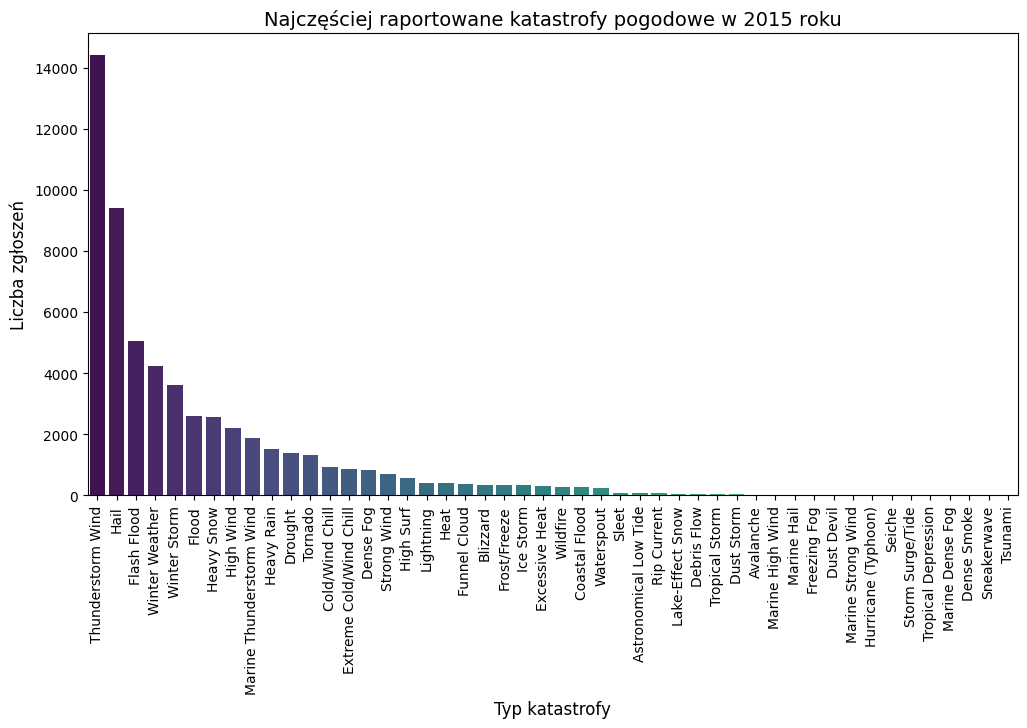

In [21]:
from gosia_utils import plot_event_counts

plot_event_counts(df)

##### tutaj orientacyjnie ktore katastrify sa najczestsze, thunderstorm,  hail oraz flash flood przeważa -> dalej analiza tych 3 katastrof dla lepszej czytelności

c:\Users\HP\studia\trzeci rok\semestr6\Projekt Interdyscplinarny\gosia_utils.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])


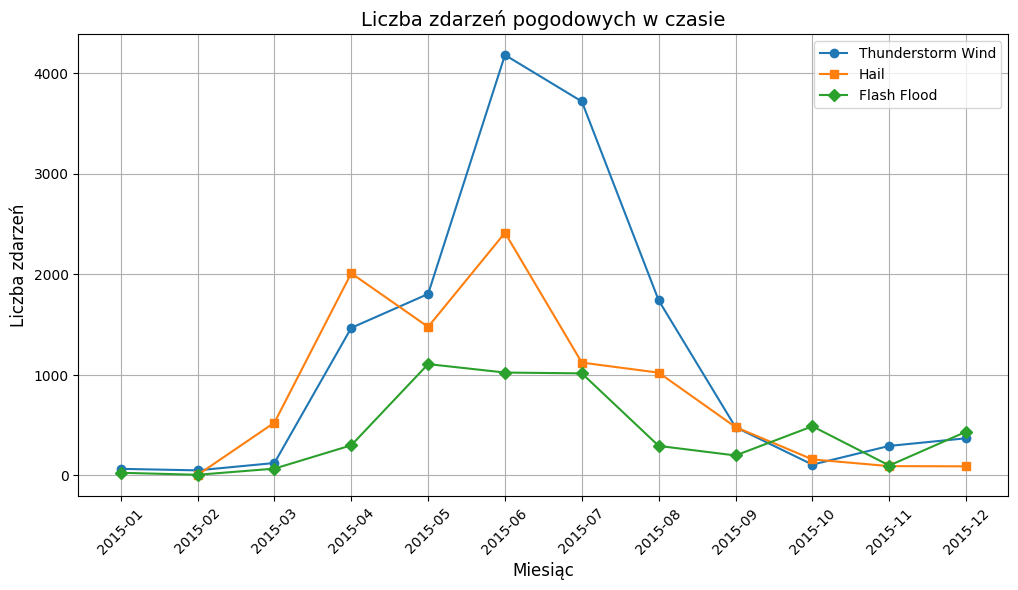

In [3]:
plot_event_trends(df)

##### tutaj rozkład jak to wyglada w czasie, widać że większośc katastrof jest w lato

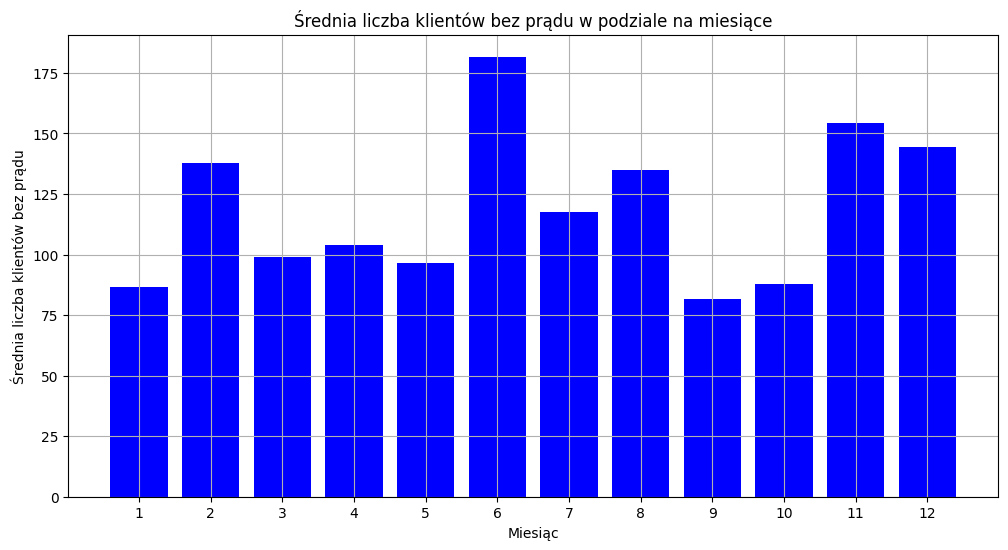

In [19]:
plot_monthly_avg_outages(out)

<Figure size 1200x600 with 0 Axes>

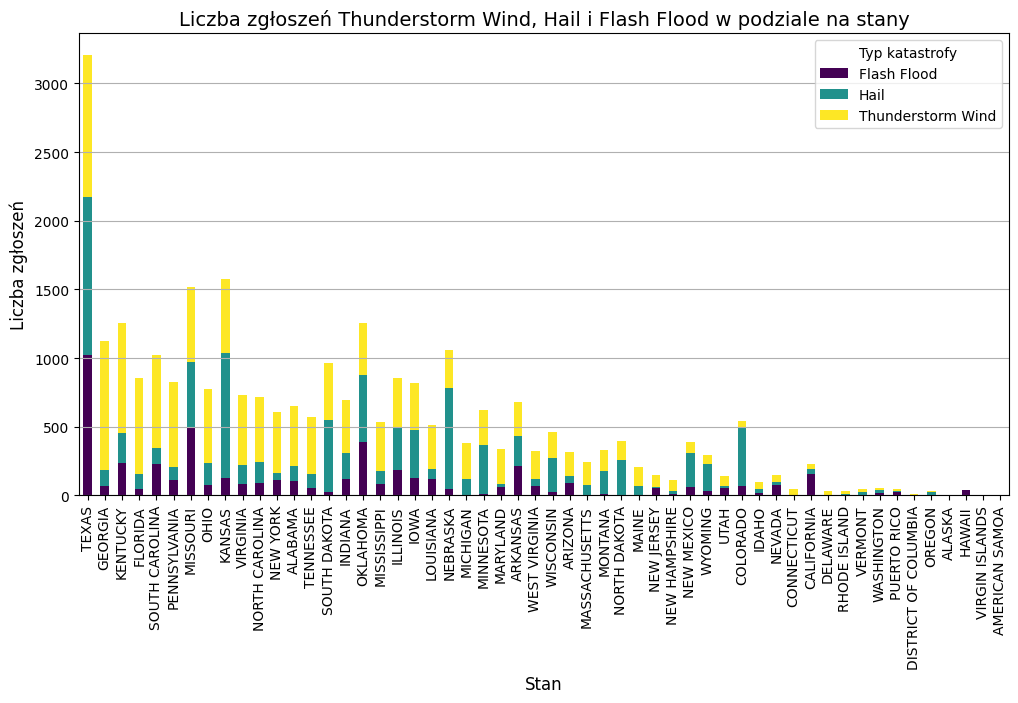

In [ ]:
from gosia_utils import plot_state_event_counts, plot_county_event_counts

plot_state_event_counts(df)


c:\Users\HP\studia\trzeci rok\semestr6\Projekt Interdyscplinarny\gosia_utils.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['COUNTY_STATE'] = df_filtered['CZ_NAME'] + " (" + df_filtered['STATE'] + ")"


<Figure size 1200x600 with 0 Axes>

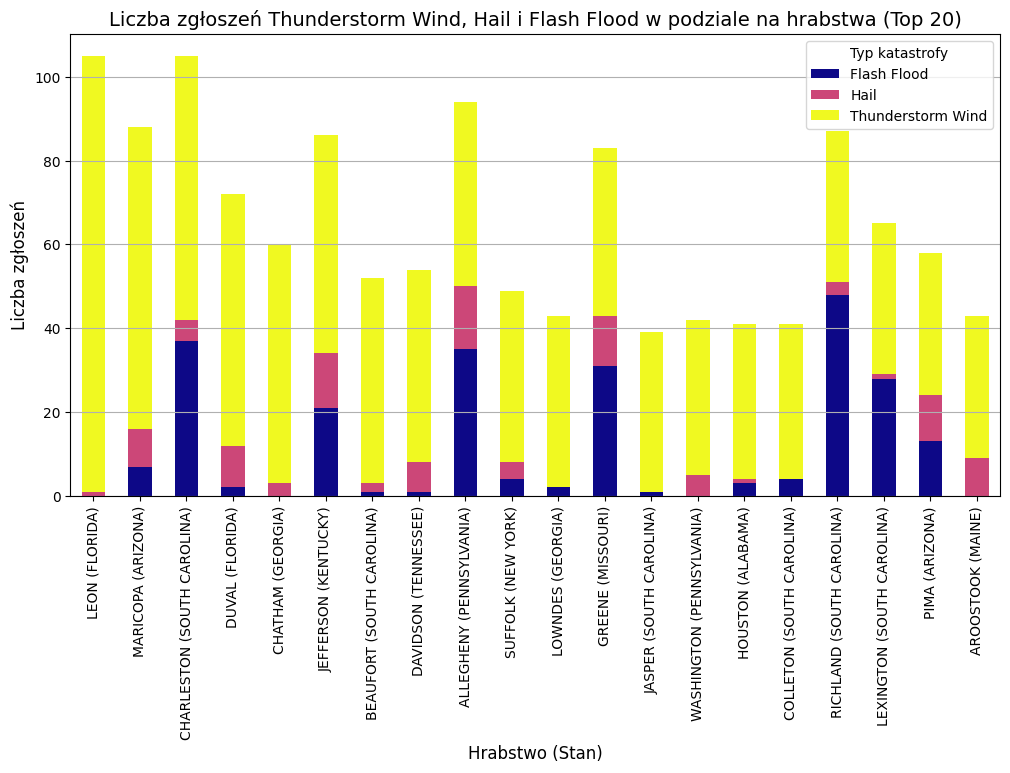

In [6]:
plot_county_event_counts(df)

C:\Users\HP\AppData\Local\Temp\ipykernel_20500\3316936323.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])


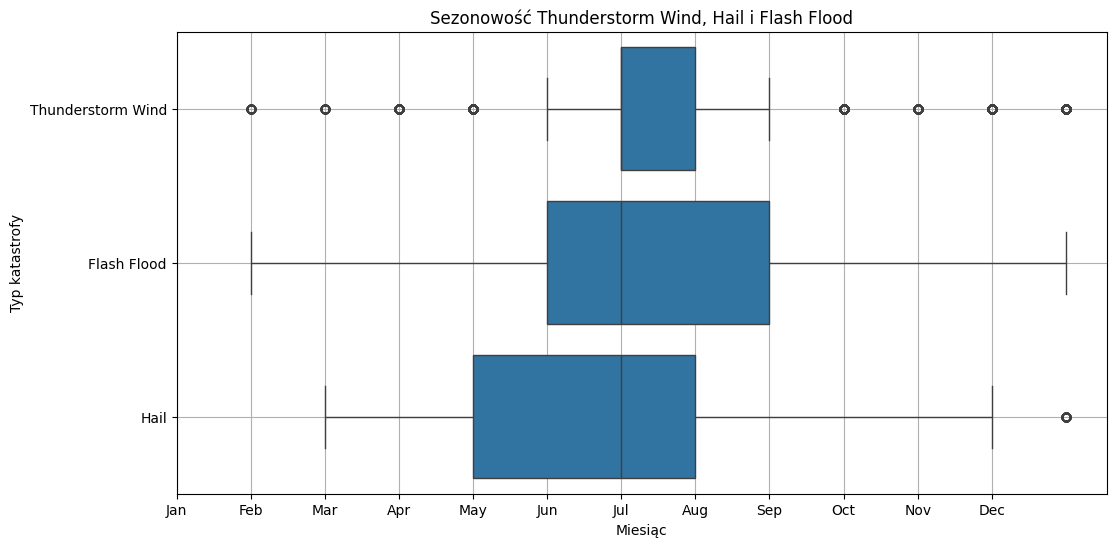

In [ ]:
from gosia_utils import plot_event_seasonality, plot_customer_outages_seasonality

plot_event_seasonality(df)

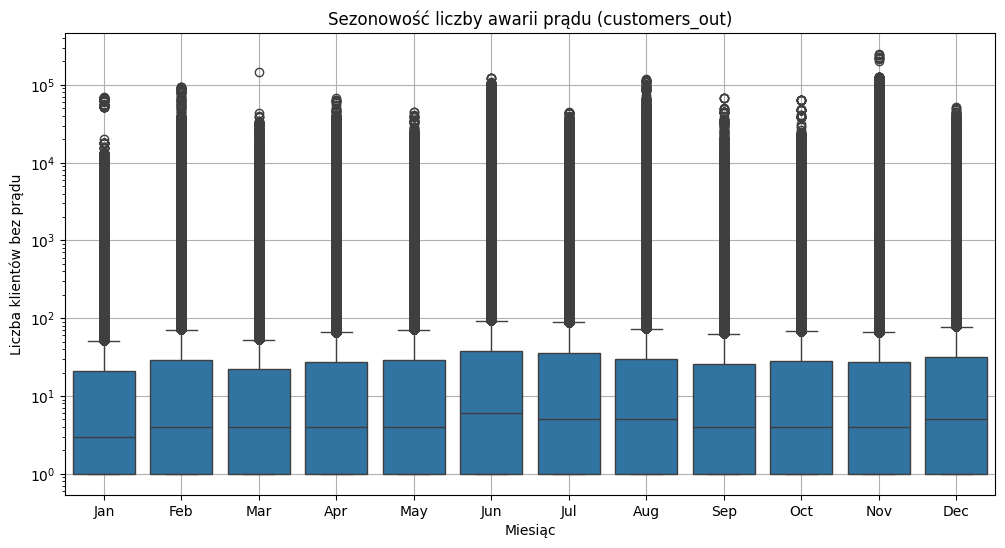

In [22]:
plot_customer_outages_seasonality(out)

##### W USA jest 3 144 hrabstw

In [ ]:
df[df['CZ_TYPE'] == 'C']['CZ_NAME'].nunique()  ### a tyle jest w roku 2015

1771

#### Czyszczenie danych

In [3]:
def convert_damage(value):
    if pd.isna(value) or value == '': 
        return 0.0
    value = str(value).upper().strip()  
    if value.endswith('K'): 
        return float(value.replace('K', '')) * 1_000
    elif value.endswith('M'):
        return float(value.replace('M', '')) * 1_000_000
    elif value.endswith('B'):
        return float(value.replace('B', '')) * 1_000_000_000
    else: 
        return float(value)

df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage)
df['DAMAGE_CROPS'] = df['DAMAGE_CROPS'].apply(convert_damage)
df['MAGNITUDE'] = df['MAGNITUDE'].replace('', 0).fillna(0) 

### Dalsza analiza - straty majątkowe oraz w ludziach

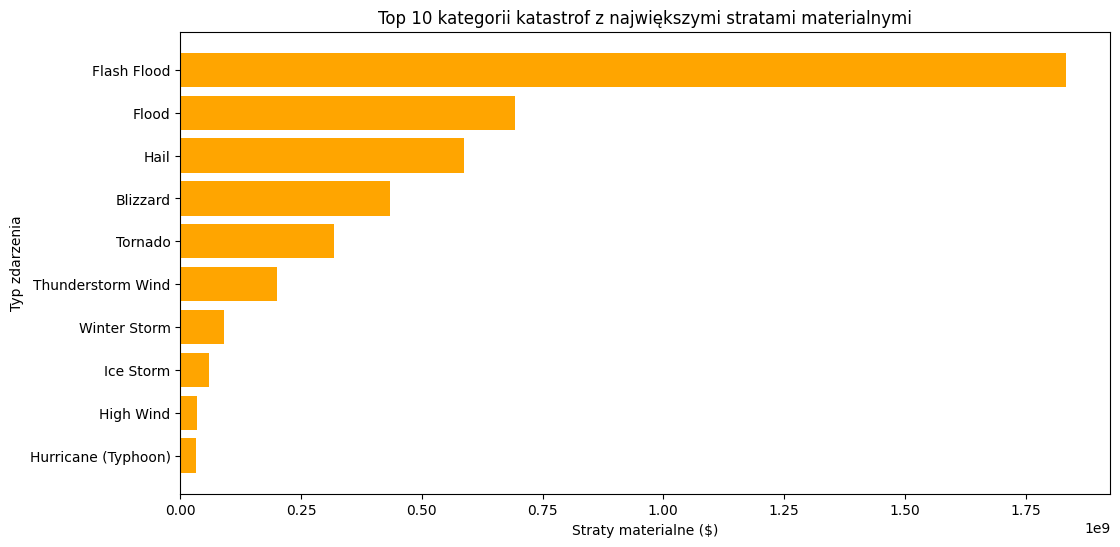

In [ ]:
from gosia_utils import plot_top_damage_events
plot_top_damage_events(df)

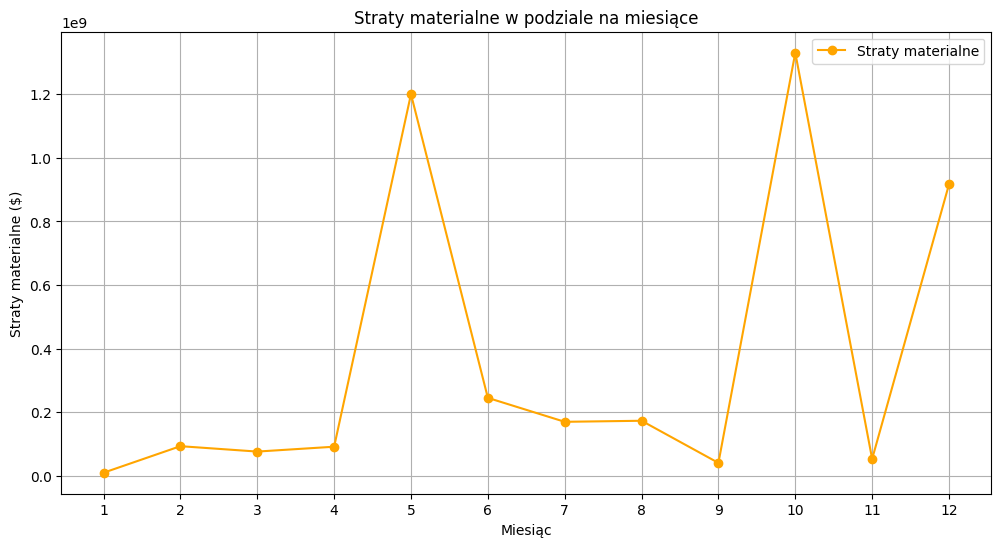

In [ ]:
from gosia_utils import plot_monthly_damage

plot_monthly_damage(df)

#### Największe straty występują w maju (5) i październiku (10)

 ### Nagłe skoki wartości – bardzo wysokie wartości w maju i październiku w porównaniu do pozostałych miesięcy sugerują, że w tych miesiącach wystąpiły pojedyncze, ekstremalne katastrofy

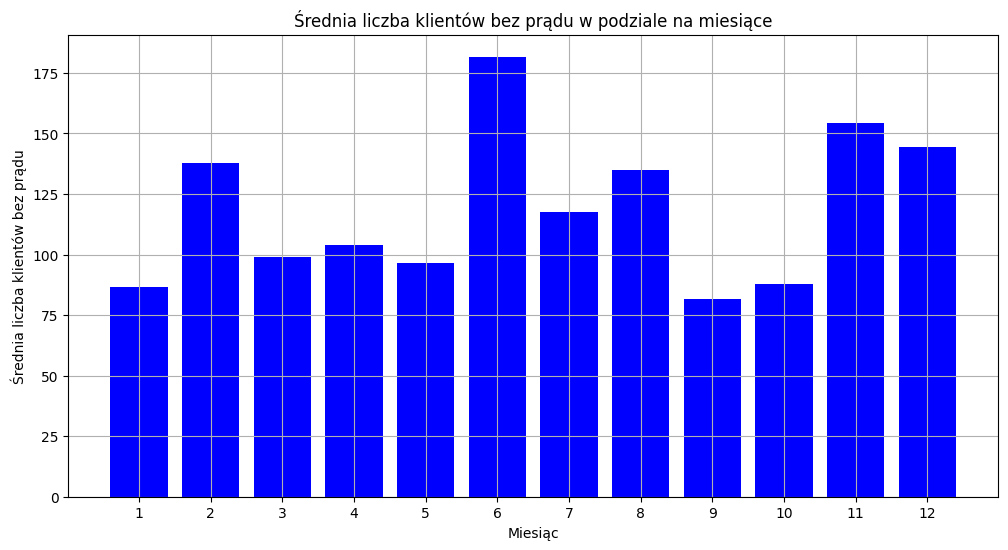

In [ ]:
from gosia_utils import plot_monthly_avg_outages

plot_monthly_avg_outages(out)

## Straty materialne i awarie prądu nie zawsze są skorelowane – niektóre katastrofy powodują duże straty finansowe, ale niekoniecznie zakłócają dostawy prądu

#### Jaka część zdarzeń kończy się i zaczyna w tej samej lokalizacji?

    - z kodu ponizej wynika, że tylko 420 zdarzeń z całych 60 000 kończy się na innej szerokości i długości gepgraficznej (mało bardzo)

In [9]:

df['BEGIN_LAT'].fillna(0, inplace=True)
df['END_LAT'].fillna(0, inplace=True)

df['BEGIN_LAT_ROUNDED'] = df['BEGIN_LAT'].round().astype(int)
df['BEGIN_LON_ROUNDED'] = df['END_LAT'].round().astype(int)

filtered_df = df[df['BEGIN_LAT_ROUNDED'] != df['BEGIN_LON_ROUNDED']]

print(filtered_df.shape[0])

print(df.shape[0])

420
57907


C:\Users\HP\AppData\Local\Temp\ipykernel_20500\1726197644.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['BEGIN_LAT'].fillna(0, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_20500\1726197644.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

## Łączenie ramek ze sobą

####  zwracamy 2 ramki: agregujemy do pełnej godziny oraz do pełnego dnia DLA JEDNEGO HRABSTWA I JEDNEGO ROKU !!!!!!!!!!!!!!!
####  mamy datę, uśrednioine cutomers_out oraz zsumowane katastrofy, z rozróżnieneim na kategorie
####  dodatkowo dodałam uśrednione/zsumowane wartości dla innych kolumn  (damages, injuries)

In [22]:
hour, day = combine_agg_ts("BACON",
                   2015,
                   1,
                   1,
                   2015,
                   8,
                   20,
                   data_directory_power = './data/data/eaglei_data',
                   data_directory_events = './data/data/NOAA_StormEvents')

In [ ]:
hour

,injuries_direct_avg,injuries_indirect_avg,deaths_direct_avg,deaths_indirect_avg,event_count Sleet,event_count Wildfire,event_count Thunderstorm Wind,event_count Funnel Cloud,event_count Tornado,event_count Flood,event_count Tropical Storm,event_count Winter Storm,event_count Heavy Rain,event_count Hurricane,customers_out
time,,,,,,,,,,,,,,,
2015-01-09 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-09 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-09 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-09 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-09 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
hour, day = combine_agg_ts("BACON",
                   2015,
                   1,
                   1,
                   2015,
                   8,
                   20,
                   data_directory_power = './data/data/eaglei_data',
                   data_directory_events = './data/data/NOAA_StormEvents')

       YEAR  MONTH  DAY                time  injuries_direct_avg  \
15617  2015      6   12 2015-06-12 16:15:00                  0.0   
16099  2015      6   17 2015-06-17 16:45:00                  0.0   

       injuries_indirect_avg  deaths_direct_avg  deaths_indirect_avg  \
15617                    0.0                0.0                  0.0   
16099                    0.0                0.0                  0.0   

       event_count Sleet  event_count Wildfire  event_count Thunderstorm Wind  \
15617                  0                     0                              2   
16099                  0                     0                              2   

       event_count Funnel Cloud  event_count Tornado  event_count Flood  \
15617                         0                    0                  0   
16099                         0                    0                  0   

       event_count Tropical Storm  event_count Winter Storm  \
15617                           0            

In [42]:
day[day['event_count Thunderstorm Wind'] > 0]

,injuries_direct_avg,injuries_indirect_avg,deaths_direct_avg,deaths_indirect_avg,event_count Sleet,event_count Wildfire,event_count Thunderstorm Wind,event_count Funnel Cloud,event_count Tornado,event_count Flood,event_count Tropical Storm,event_count Winter Storm,event_count Heavy Rain,event_count Hurricane,customers_out
time,,,,,,,,,,,,,,,
2015-06-12,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,396.500
2015-06-17,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212.375
2015-07-02,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
2015-07-14,0.0,0.0,0.0,0.0,0.0,0.0,0.010417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.000


In [41]:
day.columns


Index(['injuries_direct_avg', 'injuries_indirect_avg', 'deaths_direct_avg',
       'deaths_indirect_avg', 'event_count Sleet', 'event_count Wildfire',
       'event_count Thunderstorm Wind', 'event_count Funnel Cloud',
       'event_count Tornado', 'event_count Flood',
       'event_count Tropical Storm', 'event_count Winter Storm',
       'event_count Heavy Rain', 'event_count Hurricane', 'customers_out'],
      dtype='object')

#### Wnioski z łączenia kolumn:
    - aby stworzyć końcową ramkę możemy skorzystać z tej funkcji dla pojedynczego hrabstwa, tylko forem przelecieć po wszystkich
    - nie wiem dlaczego zliczanie katastrof nie jest zliczaniem tylko częstością????   PLS HELP
    - można agregować i dodawać kolejne kolumny, jeśli będziemy potrzebować
    - 

# TO DO:
    - Dlaczego ta funkcja łącząca nie zwraca liczb całkowitych tylko ułamek?
    - Połączyć nasze pliki .py i notebooki w jedną sensowną całość
    - Co zrobić z brakującymi hrabstwami?
    - Dodać więcej wniosków, przyda się dla prowadzącego i na konkurs
    - idk ...

In [ ]:
#### dodatkowo - funkcja do generowania tabeli z nullami

In [ ]:
import pandas as pd
import numpy as np

def generate_county_tables(counties, start_date, end_date, freq="15T"):
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq)
    tables = []
    
    for county in counties:
        df = pd.DataFrame({
            "County": county,
            "Customer_out": np.nan,
            "Data": date_range
        })
        tables.append(df)

    return pd.concat(tables, ignore_index=True)

counties_list = ["Essex", "Bacon"]
start = "2012-01-01"
end = "2012-03-01"

result = generate_county_tables(counties_list, start, end)


  County  Customer_out                Data
0  Essex           NaN 2012-01-01 00:00:00
1  Essex           NaN 2012-01-01 00:15:00
2  Essex           NaN 2012-01-01 00:30:00
3  Essex           NaN 2012-01-01 00:45:00
4  Essex           NaN 2012-01-01 01:00:00
      County  Customer_out                Data
11517  Bacon           NaN 2012-02-29 23:00:00
11518  Bacon           NaN 2012-02-29 23:15:00
11519  Bacon           NaN 2012-02-29 23:30:00
11520  Bacon           NaN 2012-02-29 23:45:00
11521  Bacon           NaN 2012-03-01 00:00:00


C:\Users\HP\AppData\Local\Temp\ipykernel_19464\1998965493.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq=freq)


In [55]:
type(result)
result.head()

,County,Customer_out,Data
0,Essex,NaN,2012-01-01 00:00:00
1,Essex,NaN,2012-01-01 00:15:00
2,Essex,NaN,2012-01-01 00:30:00
3,Essex,NaN,2012-01-01 00:45:00
4,Essex,NaN,2012-01-01 01:00:00


### idea:
    - bierzemy listę hrabstw w USA
    - bierzemy przedział czasowy
    - generujemy ramkę danych dla wybranego roku
    - łączymy joinem z istniejącą już ramką power_outage po dacie i hrabstwie
    - jeśli wiersz istniał w power_outage to mamy niezerowy wynik customer_out
    - jeśli nie istniał to zostaje null
### problem:
    - wiersza w ramce danych może nie być z 2 powodów:
        - brak danych
        - po prostu w tym czasie nie było żadnych power outage